### FORMAT LINKS

In [1]:
import os, csv, re, requests, pandas as pd, urlexpander
from bs4 import BeautifulSoup
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [2]:
# csv_path = '....'

#change this variable to the relevant handle
handle = 'suworow_institut'

raw_links = []

#file path to the input txt file containing raw links. **Note the file naming convention**
raw_links_path = '.....' + handle + '.txt'
if raw_links_path =='':
    raw_links_path = input('Please enter path to raw links file: ')

#file path to where file containing cleaned links will be saved
cleaned_links_path = '...'

if not os.path.exists(raw_links_path):
    os.makedirs(raw_links_path)

with open(raw_links_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        raw_links.append(line.replace("\n", ""))

In [3]:
#This cell replaces all of the shortened URLs within our raw list of URLs with expanded URLs

headers = {"user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64)\
AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.5615.121 Safari/537.36"}

not_shortened_links = []
expanded_urls_list = []
shortened_urls_garbage = []

#known_shorteners contains a list of url shorteners that will
#be used to extract shortened URLs from raw_links
known_shorteners = urlexpander.constants.all_short_domains.copy()
known_shorteners += ['youtu.be', 'shorturl.me']

#produce a list containing only shortened URLs
shortened_urls_list = [link for link in raw_links if urlexpander.is_short(link, list_of_domains=known_shorteners)]

#errors_df is a pandas dataframe containing error messages
errors_df = pd.DataFrame({'url': [],
                          'error_message': [],
                          'platform': []})

#produce a list consisting of expanded URLs
# expanded_urls_list = urlexpander.expand(shortened_urls_list[:50])
def unshorten_url(url):
    if not re.match('https?://', url):
        url = 'https://' + url
    session = requests.Session()  # so connections are recycled
    try:
        resp = session.head(url, allow_redirects=True)
        unshortened_url = re.sub('https?://(www\.)?', '', resp.url)
        expanded_urls_list.append(unshortened_url)
    except Exception as error:
        print(error)
        print(url)
        if len(re.findall("(?<=host=').*(?=', port)", str(error))) != 0:
            unshortened_url = re.findall("(?<=host=').*(?=', port)", str(error))
            unshortened_url = re.sub('https?://(www\.)?', '', unshortened_url[0])
            expanded_urls_list.append(unshortened_url)
        else:
            shortened_urls_garbage.append(url)
            errors_df.loc[len(errors_df.index)] = [url, error, 'shortened_url']
    
for url in shortened_urls_list:
    unshorten_url(url)

#substract shortened URLs from raw_links to produce not_shortened_links
for link in raw_links:
    if not urlexpander.is_short(link, list_of_domains=known_shorteners):
        not_shortened_links.append(link)

#combine not_shortened_links with expanded_urls_list
raw_with_expansion = not_shortened_links + expanded_urls_list
raw_with_expansion = [re.sub('https?://(www\.)?', '', i) for i in raw_with_expansion] 

# del shortened_urls_list
# del not_shortened_links
# del expanded_urls_list

HTTPSConnectionPool(host='wp.me', port=443): Max retries exceeded with url: /p8Ievb-fQ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x139307390>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
https://t.co/Ps97ynRh20
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
https://bit.ly/3Mb4rUk
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
https://bit.ly/3QNYAHv
HTTPSConnectionPool(host='fb.me', port=443): Max retries exceeded with url: /e/25Cl9wUIx (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x139329790>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
https://fb.me/e/25Cl9wUIx


In [4]:
discarded = len(raw_links) - len(raw_with_expansion + shortened_urls_garbage)

print(f'{discarded} links have been lost up to this point')

0 links have been lost up to this point


In [5]:
sm_urls_list = []
non_sm_urls_list = []
sm_other_urls_list = []
fb_watch_list = []
youtube_watch_list = []
vk_list = []

tiktok_garbage = []
ig_garbage = []
youtube_garbage = []
facebook_garbage = []
twitter_garbage = []
bitchute_garbage = []
odysee_garbage = []
rumble_garbage = []
gettr_garbage = []
mail_garbage = []
garbage = []


sm_platforms_re = '^(m\.|mobile\.)?(odysee|vk\.|instagram|twitter|facebook|fb\.watch|youtube\.com|t\.me|tiktok\.|vm\.tiktok|bitchute|gettr\.com|reddit\.|rumble\.com|gab\.com|4chan\.org).*'
sm_filter = re.compile(sm_platforms_re)
sm_with_expansion = [i for i in raw_with_expansion if sm_filter.match(i)]

for link in raw_with_expansion:
    if re.match('(css|photos|messages|#go_to_message|\)\[\^)', link):
        garbage.append(link)
    elif re.match('mailto', link):
        mail_garbage.append(link)
    elif link in sm_with_expansion:
        continue
    else:
        non_sm_urls_list.append(re.sub('/.*', '', link))
    

sm_with_expansion = [re.sub('^(m\.|mobile\.)', '', i) for i in sm_with_expansion if not re.match('m\.tiktok\.com', i)]
for link in sm_with_expansion:
    if re.match('(instagram\.com/p/|instagram\.com/tv)', link):
        ig_garbage.append(link)
    elif re.search('(twitter\.com/.*/status|facebook\.com/.*/posts|reddit\.com/r/.*/comments)', link):
        link = re.sub('(/status.*|/posts.*|/comments.*)', '', link)
        sm_urls_list.append(link)
    elif re.match('twitter\.com/hashtag', link):
        twitter_garbage.append(link)
    elif re.search('facebook\.com/.*/videos', link):
        link = re.sub('/videos.*', '', link)
        sm_urls_list.append(link)
    elif re.match('(facebook\.com/watch|fb\.watch)', link):
        fb_watch_list.append(link)
    elif re.match('facebook\.com/story', link):
        facebook_garbage.append(link)
    elif re.match('t\.me/', link):
        link = re.findall('t\.me/[-+_a-zA-Z0-9]*', link)
        sm_urls_list.append(link[0])
    elif re.search('youtube\.com/c/', link):
        link = re.sub('/c/', '/@', link)
        sm_urls_list.append(link)
    elif re.search('youtube\.com/channel', link):
        try:
            page_content = requests.get('https://' + link, headers=headers).content
            if len(re.findall('(?<="webCommandMetadata":{"url":"/).*(?=/featured)', str(page_content))) != 0:
                link = re.findall('(?<="webCommandMetadata":{"url":"/).*(?=/featured)', str(page_content))
                link = 'youtube.com/' + link[0]
#                 print('yt channel: ' + link)
                sm_urls_list.append(link)
            else:
                youtube_garbage.append(link)
        except Exception as error:
            errors_df.loc[len(errors_df.index)] = [link, error, 'youtube'] 
#                 print(error)
            youtube_garbage.append(link)
    elif re.match('youtube\.com/results', link):
        youtube_garbage.append(link)
    elif re.match('(youtube\.com/watch|youtube\.com/live)', link):
        youtube_watch_list.append(link)
    elif re.match('odysee\.com/[^@]', link):
        try:
            page_content = requests.get('https://' + link, headers=headers).content
            if len(re.findall('(?<="og:url" content="https://)[\.@-_/a-zA-Z0-9]+', str(page_content))) != 0:
                link = re.findall('(?<="og:url" content="https://)[\.@-_/a-zA-Z0-9]+', str(page_content))[0]
                sm_urls_list.append(link)
            else:
                odysee_garbage.append(link)
        except Exception as error:
            link = re.sub('https://', '', link)
            errors_df.loc[len(errors_df.index)] = [link, error, 'odysee'] 
            odysee_garbage.append(re.sub('https://', '', link))
    elif re.match('odysee\.com/@', link):
        link = re.sub(':.*', '', link)
        sm_urls_list.append(link)
    elif re.match('bitchute\.com', link):
        try:
            page_content = requests.get('https://' + link, headers=headers).content
            link = re.findall('(?<=channel/)[-_a-zA-Z0-9]+(?=/")', str(page_content))
            link = 'bitchute.com/' + str(link[0])
            sm_urls_list.append(link)
        except Exception as error:
            errors_df.loc[len(errors_df.index)] = [link, error, 'bitchute'] 
            bitchute_garbage.append(link)
    elif re.match('vk\.com', link):
        vk_list.append(link)
    elif re.match('rumble\.com', link):
        if re.match('(rumble\.com/user/|rumble\.com/c/)', link):
            sm_urls_list.append(link)
        else:
            try:
                page_content = requests.get('https://' + link, headers=headers).content
                soup = BeautifulSoup(page_content, 'html.parser')
                if soup.find('a', class_='media-by--a').get('href') != '':
                    user_channel = soup.find('a', class_='media-by--a').get('href')
                    link = 'rumble.com' + user_channel
                    sm_urls_list.append(link)
                else:
                    rumble_garbage.append(link)
            except Exception as error:
                link = re.sub('https://', '', link)
                errors_df.loc[len(errors_df.index)] = [link, error, 'rumble']
                rumble_garbage.append(link)
    elif re.match('gettr\.com', link):
        if re.match('gettr\.com/user/', link):
            sm_urls_list.append(link)
        else:
            try:
                page_content = requests.get('https://' + link, headers=headers).content
                soup = BeautifulSoup(page_content, 'html.parser')
                if len(re.findall('.*(?= on GETTR)', soup.title.get_text())) != 0:
                    user = re.findall('.*(?= on GETTR)', soup.title.get_text())[0]
                    link = 'gettr.com/user/' + user
                    sm_urls_list.append(link)
                else:
                    gettr_garbage.append(link)
            except Exception as error:
                link = re.sub('https://', '', link)
                errors_df.loc[len(errors_df.index)] = [link, error, 'gettr']
                gettr_garbage.append(link)
    elif re.match('(vm\.tiktok|m\.tiktok|tiktok)', link):
        if re.match('(vm\.|m\.)', link):
            link = requests.head('https://' + link, allow_redirects=True).url
            link = re.sub('https://www\.', '', link)
            link = re.sub('/video.*', '', link)
            if link != 'tiktok.com/':
                sm_urls_list.append(link)
            else:
                tiktok_garbage.append(link)
        elif link.startswith('tiktok.com/@'):
            link = re.sub('\?.*', '', link)
            sm_urls_list.append(link)
        else:
            tiktok_garbage.append(link)
    else:
#             print('sm other: ' + link)
        sm_other_urls_list.append(re.sub('/$', '', link))


sm_other_urls_list = [re.sub('\?.*', '', i) for i in sm_other_urls_list]
sm_urls_list = sm_urls_list + sm_other_urls_list

In [6]:
# print(sm_other_urls_list)

In [7]:
# [re.findall('gettr.*', i) for i in sm_urls_list if re.match('gettr', i)]

In [8]:
lost = len(raw_links) - len(youtube_garbage + facebook_garbage + tiktok_garbage + bitchute_garbage + ig_garbage + odysee_garbage + garbage + rumble_garbage + gettr_garbage + twitter_garbage + shortened_urls_garbage + mail_garbage + sm_urls_list + non_sm_urls_list + fb_watch_list + youtube_watch_list + vk_list)

print(f'{lost} links have been lost up to this point')

0 links have been lost up to this point


In [9]:
yt_watch_garbage = []

for link in youtube_watch_list:
    try:
        page = requests.get('https://' + link, headers=headers)
        page_content = page.content
        soup = BeautifulSoup(page_content, "html.parser")
        content = soup.find('span', attrs={'itemprop': 'author'})
        if content.find('link', attrs={'href': re.compile('https?://')}) != '':
            link = content.find('link', attrs={'href': re.compile('https?://')})
            link = re.sub('https?://(www\.)?', '', link.get('href'))
            sm_urls_list.append(link)
        else:
            yt_watch_garbage.append(link)
    except Exception as error:
        errors_df.loc[len(errors_df.index)] = [link, error, 'youtube_watch'] 
#         print('yt watch error: ' + str(error))
        yt_watch_garbage.append(link)

# del youtube_watch_list
# del fb_watch_list

In [10]:
fb_watch_garbage = []

for link in fb_watch_list:
    link = 'https://' + link
    try:
        page = requests.get(link, headers=headers)
        page_content = page.content
        soup = BeautifulSoup(page_content, "html.parser")
        content = soup.find('link', attrs={'hreflang': 'x-default'})
        if content.get('href') != '':
            link = content.get('href')
            link = re.sub('https?://(www\.)?', '', link)
            link = re.sub('/videos.*', '', link)
            sm_urls_list.append(link)
        else:
            fb_watch_garbage.append(re.sub('https://', '', link))
    except Exception as error:
        link = re.sub('https://', '', link)
        errors_df.loc[len(errors_df.index)] = [link, error, 'fb_watch'] 
#         print('fb watch error: ' + str(error))
        fb_watch_garbage.append(link)

In [11]:
vk_garbage = []

for link in vk_list:
    try:
        if re.search('vk\.com/video/@', link):
            link = re.sub('/video/@', '/', link)
            link = re.sub('\?.*', '', link)
            sm_urls_list.append(link)
        elif re.search('vk\.com/video', link):
            page_content = requests.get('https://' + link).content
            soup = BeautifulSoup(page_content, 'html.parser')
            href_list = soup.find_all('a')
            if str(href_list[3].get('href')) != '':
                link = 'vk.com' + str(href_list[3].get('href'))
#                 print(link)
                sm_urls_list.append(link)
            else:
                vk_garbage.append(link)
        elif re.search('vk\.com/wall', link):
            page_content = requests.get('https://' + link).content
            soup = BeautifulSoup(page_content, 'html.parser')
            soup_find = soup.find('a').get('href')
            link = 'vk.com' + soup_find
            sm_urls_list.append(link)
        elif re.search('vk\.com/.*\?\w(=photo|=wall)', link):
            link = re.sub('\?.*', '', link)
            sm_urls_list.append(link)
        elif re.search('vk\.com/\w+$', link):
            page_content = requests.get('https://' + link).content
            soup = BeautifulSoup(page_content, 'html.parser')
            soup_find = soup.find('link', attrs={'rel': 'canonical'})
            if re.findall('vk\.com/[-_a-zA-Z0-9]+', str(soup_find))[0] != '':
                link = re.findall('vk\.com/[-_a-zA-Z0-9]+', str(soup_find))[0]
#                 print(link)
                sm_urls_list.append(link)
            else:
                vk_garbage.append(link)
        elif re.search('vk\.com/[\w\.]+$', link):
            sm_urls_list.append(link)
        else:
            vk_garbage.append(link)
    except Exception as error:
        errors_df.loc[len(errors_df.index)] = [link, error, 'vk'] 
        vk_garbage.append(link)
#         print('error:', link)

In [12]:
lost2 = len(raw_links) - len(sm_urls_list + garbage + facebook_garbage + mail_garbage + shortened_urls_garbage + youtube_garbage + vk_garbage + fb_watch_garbage + yt_watch_garbage + ig_garbage + bitchute_garbage + odysee_garbage + twitter_garbage + rumble_garbage + gettr_garbage + tiktok_garbage + non_sm_urls_list)

print(str(lost2) + ' links have been lost up to this point')

0 links have been lost up to this point


In [33]:
formatted_links = sm_urls_list + non_sm_urls_list
formatted_links = [i.lower() for i in formatted_links]
formatted_links = [re.sub('^www\.', '', i) for i in formatted_links]
formatted_links.sort()

with open(Path(cleaned_links_path) / (handle + '_cleaned_links.txt'), 'w') as file:
    for link in formatted_links:
        file.write(link + '\n')

In [14]:
final_sm_garbage = facebook_garbage + ig_garbage + yt_watch_garbage + vk_garbage + fb_watch_garbage + youtube_garbage + bitchute_garbage + odysee_garbage + rumble_garbage + gettr_garbage + twitter_garbage + tiktok_garbage

#final_overall_garbage will tell us how many lines were put in a garbage
#list while converting raw_links to formatted_links.
#We want this to equal final_difference.
final_overall_garbage = len(final_sm_garbage + garbage + shortened_urls_garbage + mail_garbage)

#final_difference will tell us how many lines were discarded in the process
#of converting raw_links to formatted_links
final_difference = len(raw_links) - len(formatted_links)

#garbage_less_difference will tell us how many of the lines that were discarded 
#in the process of converting raw_links to  formatted_links are unaccounted for 
#by final_overall_garbage. We want this to equal zero.
garbage_less_difference = final_overall_garbage - final_difference

garbage_df = pd.DataFrame({
    'type': ['garbage', 'facebook', 'instagram', 'youtube', 'yt_watch', 'fb_watch', 'vkontakte', \
             'bitchute', 'odysee', 'rumble', 'gettr', 'tiktok', 'shortened_urls'],
    'count': [len(garbage), len(facebook_garbage), len(ig_garbage), len(youtube_garbage), len(yt_watch_garbage), \
              len(fb_watch_garbage), len(vk_garbage), len(bitchute_garbage), len(odysee_garbage), len(rumble_garbage), \
              len(gettr_garbage), len(tiktok_garbage), len(shortened_urls_garbage)]
})

garbage_df = garbage_df.sort_values('count', ascending=False)

print("{0} links were successfully converted.\n\n{1} links were lost and are unaccounted for by \
final_overall_garbage.\n\n{2} URLs are included in final_sm_garbage, which is {3}% of \
formatted_links + final_sm_garbage.\n\n{4} lines in total were discarded in the process of \
converting raw_links to formatted_links, of which {5} were non-links.\n\n{6} shortened_urls \
could not be converted and were discarded. There were {7} errors".format(str(len(formatted_links)), str(garbage_less_difference),\
                                                  str(len(final_sm_garbage)),round((len(final_sm_garbage)/\
                                                                                    len(formatted_links + final_sm_garbage))*100, 2),\
                                                  str(final_difference), len(garbage), len(shortened_urls_garbage), len(errors_df)))

print("\n\nThe number of lines included in each garbage bin are:\n\n {0}".format(garbage_df.to_string(index=False)))

3264 links were successfully converted.

0 links were lost and are unaccounted for by final_overall_garbage.

19 URLs are included in final_sm_garbage, which is 0.58% of formatted_links + final_sm_garbage.

50 lines in total were discarded in the process of converting raw_links to formatted_links, of which 14 were non-links.

2 shortened_urls could not be converted and were discarded. There were 19 errors


The number of lines included in each garbage bin are:

           type  count
      yt_watch     16
       garbage     14
shortened_urls      2
     instagram      1
      fb_watch      1
        tiktok      1
      facebook      0
       youtube      0
     vkontakte      0
      bitchute      0
        odysee      0
        rumble      0
         gettr      0


In [15]:
final_sm_garbage

['instagram.com/p/Cak-tmtNozh/?utm_medium=copy_link',
 'youtube.com/watch?feature=youtu.be&amp;v=pRsStFJgffc',
 'youtube.com/watch?feature=youtu.be&amp;v=fSbWhQy-5zk',
 'youtube.com/watch?feature=youtu.be&amp;v=gT3dgTLBZh0',
 'youtube.com/watch?v=um3_6NM6II4',
 'youtube.com/watch?app=desktop&amp;v=BKzkJS8e9aU',
 'youtube.com/watch?app=desktop&amp;v=qN3Q9PSjY2M',
 'youtube.com/watch?v=SdDkZvOxEGg',
 'youtube.com/watch?v=8hrwazuQrQY',
 'youtube.com/watch?v=8hrwazuQrQY',
 'youtube.com/watch?v=xvt2sRjhwss&feature=youtu.be',
 'youtube.com/watch?v=xvt2sRjhwss&feature=youtu.be',
 'youtube.com/watch?v=vGqVFdQexq4&feature=youtu.be',
 'youtube.com/watch?v=BzSlNjkQkDA&feature=youtu.be',
 'youtube.com/watch?v=-VbtNWE5jlI&feature=youtu.be',
 'youtube.com/watch?v=1PgFLT059fM&feature=youtu.be',
 'youtube.com/watch?v=K_O4BrwHWH4&feature=youtu.be',
 'fb.watch/jDnI4JCSyv/',
 'tiktok.com/']

In [16]:
len(errors_df)

19

In [17]:
platform_filter = 'youtube_watch'

print("\nfilters include: {0}".format(errors_df['platform'].unique()))

print('\n\nthe following are the error counts for each platform type \
that produced an error: \n\n{0}'.format(errors_df['platform'].value_counts()))


filters include: ['shortened_url' 'youtube_watch' 'fb_watch']


the following are the error counts for each platform type that produced an error: 

platform
youtube_watch    16
shortened_url     2
fb_watch          1
Name: count, dtype: int64


In [18]:
errors_df[errors_df['platform']==platform_filter].head(10)

,url,error_message,platform
2,youtube.com/watch?feature=youtu.be&amp;v=pRsSt...,'NoneType' object has no attribute 'find',youtube_watch
3,youtube.com/watch?feature=youtu.be&amp;v=fSbWh...,'NoneType' object has no attribute 'find',youtube_watch
4,youtube.com/watch?feature=youtu.be&amp;v=gT3dg...,'NoneType' object has no attribute 'find',youtube_watch
5,youtube.com/watch?v=um3_6NM6II4,'NoneType' object has no attribute 'find',youtube_watch
6,youtube.com/watch?app=desktop&amp;v=BKzkJS8e9aU,'NoneType' object has no attribute 'find',youtube_watch
7,youtube.com/watch?app=desktop&amp;v=qN3Q9PSjY2M,'NoneType' object has no attribute 'find',youtube_watch
8,youtube.com/watch?v=SdDkZvOxEGg,'NoneType' object has no attribute 'find',youtube_watch
9,youtube.com/watch?v=8hrwazuQrQY,'NoneType' object has no attribute 'find',youtube_watch
10,youtube.com/watch?v=8hrwazuQrQY,'NoneType' object has no attribute 'find',youtube_watch
11,youtube.com/watch?v=xvt2sRjhwss&feature=youtu.be,'NoneType' object has no attribute 'find',youtube_watch


In [19]:
len(formatted_links)

3264

--------------------------------------------------------
   ### LINK ANALYSIS

In [20]:
import matplotlib.pyplot as plt, seaborn as sns

In [21]:
top = 10

from_path_forwards = '/.../TG_forwards_edges_list.csv'

save_path = os.path.join('...', handle)

if not os.path.exists(save_path):
    os.makedirs(save_path)

In [22]:
df_links_clean = pd.Series(formatted_links)
df_forwards = pd.read_csv(from_path_forwards)

In [23]:
df_links_clean.value_counts().head(10)

t.me/identarist_en               134
youtube.com/@suworowtv            97
t.me/ostnews_faktencheck          90
t.me/slavyangrad                  88
t.me/newresistance                85
t.me/intelrepublic                81
t.me/rot_okt                      78
geopolitika.ru                    66
twitter.com/rot_okt               58
youtube.com/@roteroktober3819     55
Name: count, dtype: int64

In [24]:
df_forwards[df_forwards['source']==handle].value_counts().head(10)

source            target             
suworow_institut  intelslava             209
                  EurasianChoice          72
                  alexandermarkovics      71
                  NewResistance           56
                  neuesausrussland        54
                  Dugin_Aleksandr         42
                  Slavyangrad             41
                  ninabyzantina           31
                  IntelRepublic           29
                  ostnews_faktencheck     26
Name: count, dtype: int64

In [25]:
from collections import Counter

#URL count
urls_list = []
urls_count_list = []
urls_counter = Counter()

for i in df_links_clean:
    urls_counter.update(i.split())
    
for i in urls_counter:
    urls_list.append(i)
    urls_count_list.append(urls_counter[i])

In [26]:
#TG forwards count
forwards_list = []
forwards_count_list = []
forwards_counter = Counter()

for i in df_forwards[df_forwards['source']==handle]['target']:
    forwards_counter.update(i.split())
    
for i in forwards_counter:
    forwards_list.append(i)
    forwards_count_list.append(forwards_counter[i])

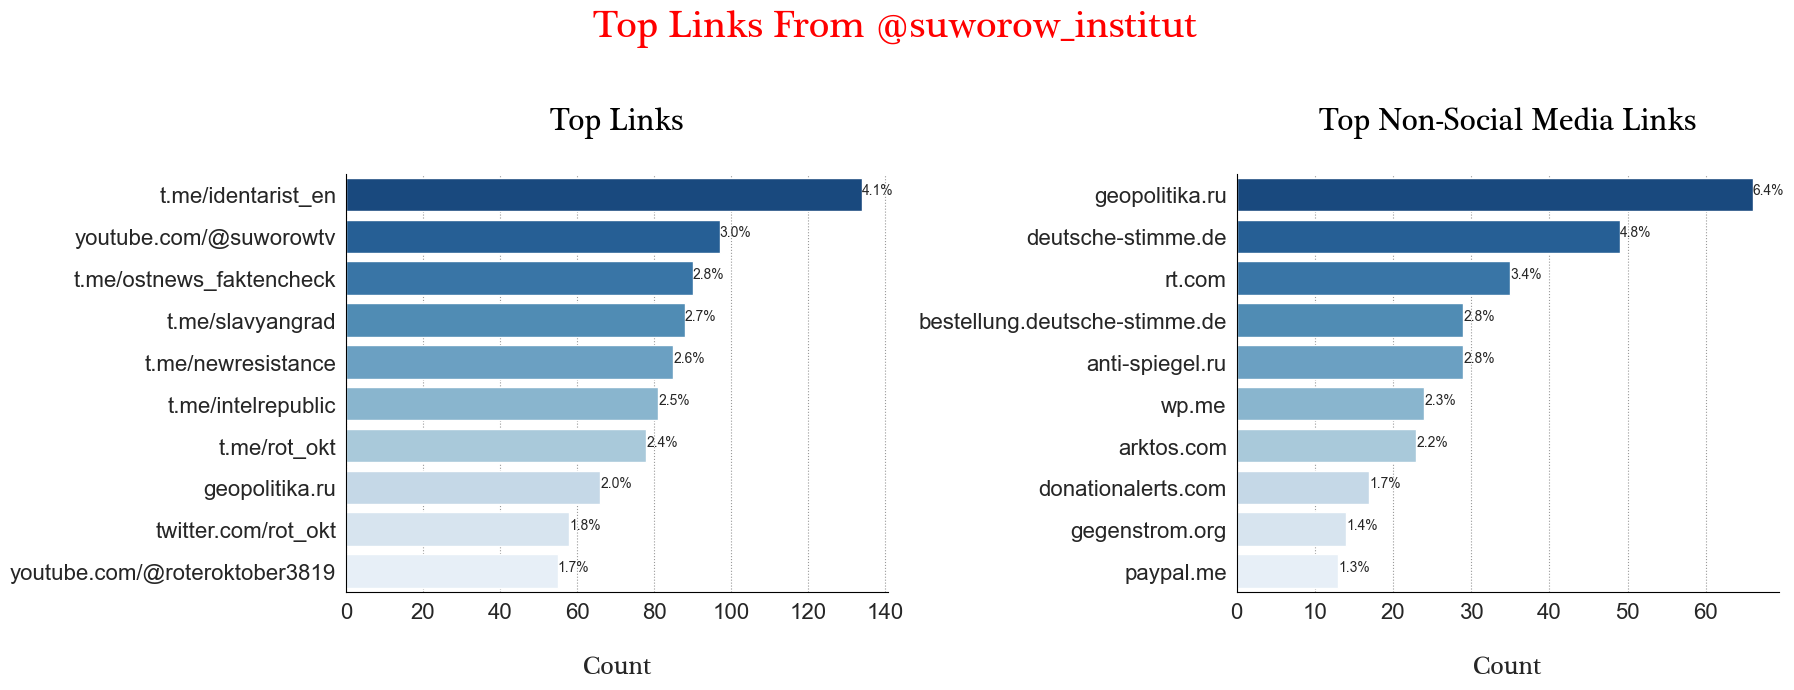

In [27]:
#visualize most frequently linked to URLs
sns.set_style\
('whitegrid', {"grid.color": ".6", "grid.linestyle": ":", 'axes.edgecolor': 'Black', 
             'axes.grid': True})

f, axes = plt.subplots(1,2, figsize=(18,7))


##ALL URLS##
all_urls_df = pd.DataFrame({'urls': urls_list,
                          'url_count': urls_count_list}).sort_values\
('url_count', ascending=False)[:top]

ax1 = sns.barplot(data=all_urls_df, y='urls', x='url_count', palette='Blues_r', ax=axes[0])

ax1.set(ylabel=None)
ax1.set_xlabel('\nCount', fontsize=18, fontweight='bold', fontname="Plantagenet Cherokee")
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.set_title('Top Links\n', fontsize=22,\
         fontweight='bold', fontname="Plantagenet Cherokee", color='Black')

total = len(formatted_links)
for p in ax1.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax1.annotate(percentage, (x, y))


##MINUS SOCIAL MEDIA URLS##
urls_df = pd.DataFrame({'urls': urls_list,
                          'url_count': urls_count_list}).sort_values\
('url_count', ascending=False)

non_sm_df = urls_df[~urls_df['urls'].str.contains\
                             (sm_platforms_re, case=False, regex=True)][:top]
    

ax2 = sns.barplot(data=non_sm_df, y='urls', x='url_count', palette='Blues_r', ax=axes[1])

ax2.set(ylabel=None)
ax2.set_xlabel('\nCount', fontsize=18, fontweight='bold', fontname="Plantagenet Cherokee")
ax2.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='x', labelsize=16)
ax2.set_title('Top Non-Social Media Links\n', fontsize=22,\
         fontweight='bold', fontname="Plantagenet Cherokee", color='Black')

total = len(non_sm_urls_list)
for p in ax2.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax2.annotate(percentage, (x, y))

f.suptitle('Top Links From @' + handle + '\n', fontsize=28, fontweight='bold', color='Red', \
          fontname="Plantagenet Cherokee")

sns.despine()
plt.tight_layout()
# plt.show()

f.savefig(Path(save_path) / (handle + '_top_urls.jpg'), bbox_inches='tight')

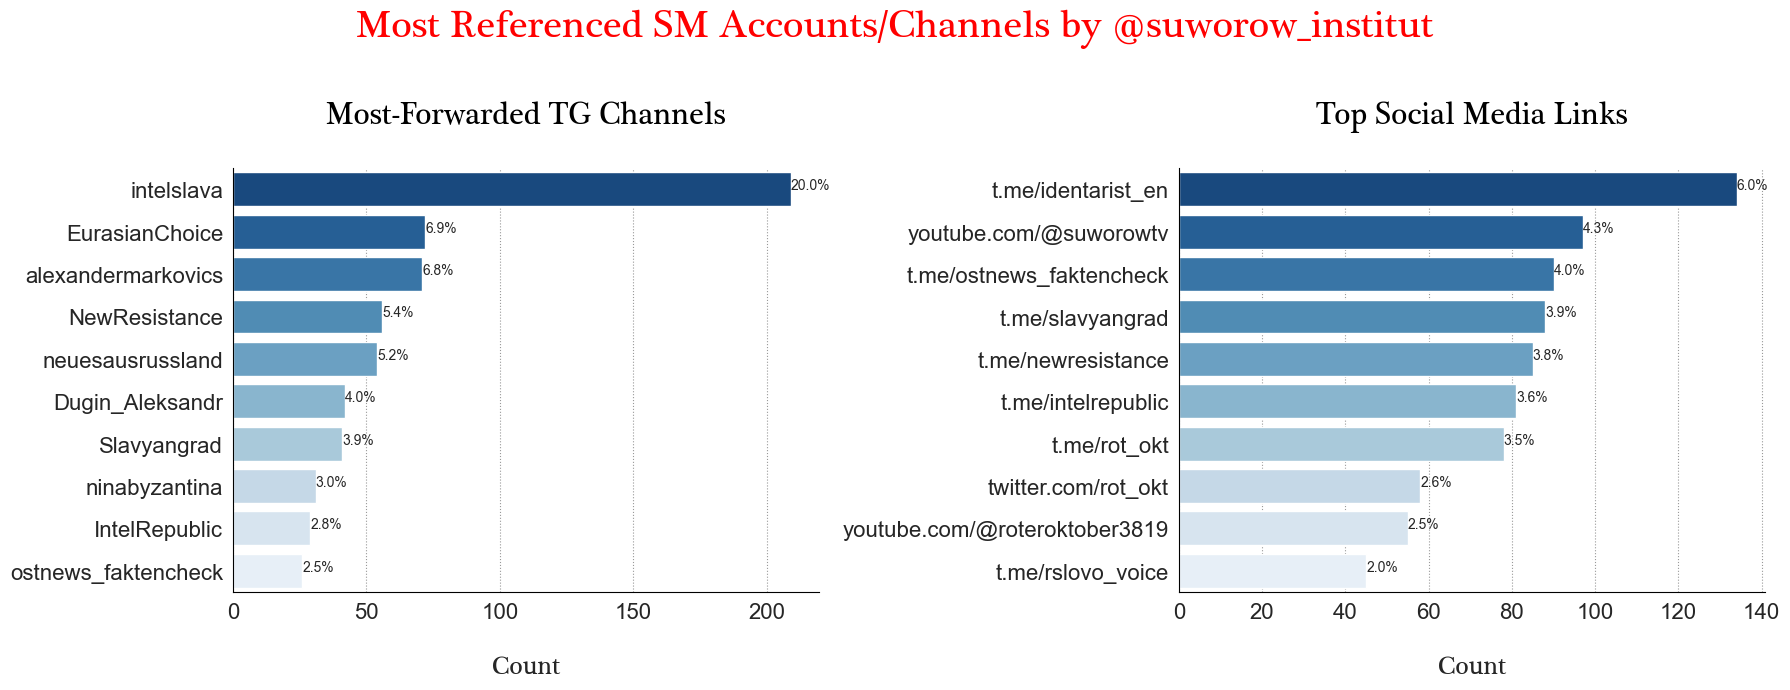

In [31]:
#visualize most frequently linked and forwarded to SM accounts/channels
f, axes = plt.subplots(1,2, figsize=(18,7))


##TG FORWARDSS##
forwards_df = pd.DataFrame({'forwards': forwards_list,
                          'forwards_count': forwards_count_list}).sort_values\
('forwards_count', ascending=False)[:top]


ax1 = sns.barplot(data=forwards_df, y='forwards', x='forwards_count', palette='Blues_r', ax=axes[0])


ax1.set(ylabel=None)
ax1.set_xlabel('\nCount', fontsize=18, fontweight='bold', fontname="Plantagenet Cherokee")
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.set_title('\nMost-Forwarded TG Channels\n', fontsize=22,\
         fontweight='bold', fontname="Plantagenet Cherokee", color='Black')

total = len(df_forwards[df_forwards['source']==handle])
for p in ax1.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax1.annotate(percentage, (x, y))


##SOCIAL MEDIA LINKS##
sm_df = urls_df[urls_df['urls'].str.contains\
                             (sm_platforms_re, case=False, regex=True)][:top]

ax2 = sns.barplot(data=sm_df, y='urls', x='url_count', palette='Blues_r', ax=axes[1])

ax2.set(ylabel=None)
ax2.set_xlabel('\nCount', fontsize=18, fontweight='bold', fontname="Plantagenet Cherokee")
ax2.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='x', labelsize=16)
ax2.set_title('\nTop Social Media Links\n', fontsize=22,\
         fontweight='bold', fontname="Plantagenet Cherokee", color='Black')

total = len(sm_urls_list)
for p in ax2.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax2.annotate(percentage, (x, y))


f.suptitle('Most Referenced SM Accounts/Channels by @' + handle, fontsize=28, fontweight='bold', color='Red', \
          fontname="Plantagenet Cherokee")

sns.despine()
plt.tight_layout()
# plt.show()

f.savefig(Path(save_path) / (handle + '_top_sm_links.jpg'), bbox_inches='tight')